# Reinforcement Learning with Q-Net

## Import packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# Load environment

## Inspect the environment spaces

In [2]:
import gym
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


## Look closer at the environment taking random actions (render() doesn't work in colab)

From the cartpole documentation:  

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
        
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        
    Reward:
        Reward is 1 for every step taken, including the termination step
        
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
        
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.

For the CartPole-v1 the max episode steps and the average reward that is needed to solve this environment actually differ:

In [3]:
print(f'Max episode steps: {env.spec.max_episode_steps}\nReward for solved: {env.spec.reward_threshold}')

Max episode steps: 500
Reward for solved: 475.0


In [4]:
observation = env.reset()
reward_sum = 0
for t in range(100):
    env.render()
    action = env.action_space.sample() # Take a random action    
    print(observation)
    print(action)
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    if done:
        print(observation)
        print(f'Episode finished after {t+1} timesteps')        
        print(f'Reward: {reward_sum}')
        break
env.close()

[-0.01156394 -0.04302008  0.00826242  0.03794434]
0
[-0.01242434 -0.23825954  0.0090213   0.33322264]
1
[-0.01718953 -0.04326714  0.01568576  0.04339818]
0
[-0.01805488 -0.23861047  0.01655372  0.34098855]
1
[-0.02282709 -0.0437279   0.02337349  0.05357133]
0
[-0.02370164 -0.23917707  0.02444492  0.35353617]
1
[-0.02848518 -0.04441109  0.03151564  0.06866057]
0
[-0.02937341 -0.23997037  0.03288885  0.37111789]
1
[-0.03417281 -0.04533073  0.04031121  0.08898391]
1
[-0.03507943  0.14919092  0.04209089 -0.19071324]
1
[-0.03209561  0.34368624  0.03827662 -0.46982675]
1
[-0.02522188  0.53824717  0.02888009 -0.75020382]
0
[-0.01445694  0.34273905  0.01387601 -0.44857436]
1
[-0.00760216  0.53766201  0.00490452 -0.73685123]
0
[ 0.00315108  0.34247266 -0.0098325  -0.4426288 ]
1
[ 0.01000053  0.53773235 -0.01868508 -0.7383949 ]
0
[ 0.02075518  0.34287335 -0.03345297 -0.45165051]
0
[ 0.02761265  0.14824008 -0.04248598 -0.16969729]
1
[ 0.03057745  0.34394358 -0.04587993 -0.47547476]
1
[ 0.03745632

# Define Q-Net class

In [5]:
class QNet(Model):
    def __init__(self, layers, num_actions):
        super(QNet, self).__init__()
        self.num_actions = num_actions
        
        self.dense_layers = [tf.keras.layers.Dense(units=num_units,
                                                   activation='relu',
                                                   name=f'Dense_layer_{i}'
                                                  ) for i, num_units in enumerate(layers)]

        self.readout_layer = tf.keras.layers.Dense(units=self.num_actions,
                                                   activation=None,
                                                   name='Readout_layer'
                                                   )

    @tf.function
    def call(self, input_state):
        for layer in self.dense_layers:
            input_state = layer(input_state)
        output = self.readout_layer(input_state)
        return output
    
    @tf.function
    def act(self, input_state, epsilon = 0):
        q_vals = self.call(input_state)
        p = tf.random.uniform([])
        if tf.greater(p,epsilon):
            action = tf.squeeze(tf.argmax(q_vals,1))
        else:
            action = tf.random.uniform([],maxval=self.num_actions,dtype=tf.int64)
        return action
    
    @tf.function
    def max_q(self, input_state):
        q_vals = self.call(input_state)
        return tf.reduce_max(q_vals,-1)
    
    @tf.function
    def q_val(self, input_state, actions):
        q_vals = self.call(input_state)
        return tf.gather(q_vals,actions,batch_dims=1)  

## Inspect Q-Net

In [6]:
qnet = QNet([16,16],env.action_space.n)
observation = env.reset()
print(f' Output: {qnet(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float32),0))}\n',
      f'Action: {qnet.act(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float32),0))}\n',
      f'Max_Q: {qnet.max_q(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float32),0))}\n',
      f'Q_Val: {qnet.q_val(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float32),0),tf.expand_dims(tf.random.uniform([1],maxval=2,dtype=tf.int64),0))}\n'
     )
qnet.summary()

 Output: [[ 0.00533039 -0.01264352]]
 Action: 0
 Max_Q: [0.00533039]
 Q_Val: [[0.00533039]]

Model: "q_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_layer_0 (Dense)        multiple                  80        
_________________________________________________________________
Dense_layer_1 (Dense)        multiple                  272       
_________________________________________________________________
Readout_layer (Dense)        multiple                  34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


# Define Experience Replay Buffer

Saves a list of tuples containing: 
- state: The current state 
- action: The current action
- reward: The reward for doing 'action' in 'state' 
- new_state: The state that is reached when doing 'action' in 'state'
- done: Indicator wether 'state' is a terminal state(Pole falling over/cart leaving window) or not

In [7]:
import random

class ERP():
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []
    
    def store(self, state, action, reward, new_state, done):
        self.buffer.insert(0,(state, action, reward, new_state, done))
        if len(self.buffer) > self.buffer_size:
            list.pop(self.buffer)
            
    def sample(self, sample_size):
        idxs = random.choices(range(len(self.buffer)), k=sample_size)
        state = tf.convert_to_tensor([self.buffer[i][0] for i in idxs],dtype=tf.float32)
        action = tf.convert_to_tensor([self.buffer[i][1] for i in idxs])
        reward = tf.convert_to_tensor([self.buffer[i][2] for i in idxs],dtype=tf.float32)
        new_state = tf.convert_to_tensor([self.buffer[i][3] for i in idxs],dtype=tf.float32)
        done = tf.convert_to_tensor([self.buffer[i][4] for i in idxs],dtype=tf.float32)
        return state, action, reward, new_state, done

## Inspect Experience Replay Buffer

In [8]:
erp = ERP(5)
print(f'Initial buffer: {erp.buffer}\n')
erp.store(observation,1,0,observation,True)
print(f'Buffer after one store: {erp.buffer}')
erp.sample(6)

Initial buffer: []

Buffer after one store: [(array([-0.03353389,  0.04775897, -0.02785544,  0.01805237]), 1, 0, array([-0.03353389,  0.04775897, -0.02785544,  0.01805237]), True)]


(<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
 array([[-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237]],
       dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1])>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
 array([[-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.04775897, -0.02785544,  0.01805237],
        [-0.03353389,  0.047

# Define the training process

#### Function to plot the models performance

In [9]:
from IPython.display import clear_output

def visualize_progress(episodes, episode, train_losses, rewards, avg_reward, goal):
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.xlim((0,episodes))
    plt.plot(train_losses,label='Training')
    plt.ylabel('Loss',fontsize=24)
    plt.title(f'Episode: {episode+1}', fontweight='bold', fontsize=30)
    plt.xticks(np.arange(0,episodes,20))    
    plt.legend()
    plt.subplot(212)
    plt.xlim((0,episodes))
    plt.plot(rewards,label='Reward')
    plt.plot(avg_reward,label='Average reward over last 100')
    plt.axhline(goal,xmax=episodes,c='g',ls='--')
    plt.ylabel('Reward',fontsize=24)
    plt.xlabel('Episode',fontsize=24)
    plt.xticks(np.arange(0,episodes,20))
    plt.legend()
    plt.show() 

In [10]:
def train_qnet(model, 
               buffer_size, 
               env, 
               max_episodes, 
               train_steps, 
               batch_size, 
               loss_function, 
               optimizer, 
               epsilon_decay, 
               epsilon_min, 
               gamma):

    # Initialize lists for later visualization.
    train_losses = []
    rewards = []
    avg_reward_over_hundred = []
    
    running_average_factor = 0.95
    
    # Initialize replay buffer
    erp = ERP(buffer_size)
    
    epsilon = 1
    
    for episode in range(max_episodes):
        
        episode_reward = 0
        running_average_loss = 0
        in_state = env.reset() 
        done = False
        
        # Collect experience, get reward
        while(not done):
            env.render()
            action = model.act(tf.expand_dims(tf.convert_to_tensor(in_state,dtype=tf.float32),0),
                               epsilon)
            out_state, reward, done, info = env.step(action.numpy())
            episode_reward += reward
            erp.store(in_state,
                      action,
                      reward,
                      out_state,
                      done
                     )
            in_state = out_state        

        # Optimize
        for _ in range(train_steps):
            s, a, r, s_1, done = erp.sample(batch_size)
            
            # Calculate target, for terminal states (done=1) the target is just the immediate reward
            target = r + gamma*model.max_q(s_1)*(1-done)
            with tf.GradientTape() as tape:
                pred = model.q_val(s,a)
                loss = loss_function(target,pred)
                gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * loss
        
        train_losses.append(running_average_loss.numpy())
        rewards.append(episode_reward)
        
        
        # Let epsilon become smaller in later episodes
        if epsilon>epsilon_min:
            epsilon = epsilon*epsilon_decay
        

        # Display stats for current episode    
        print(f'\nEpisode: {episode+1}')
        print('Train loss: ',running_average_loss.numpy())        
        print('Reward: ',episode_reward)
        print('Epsilon: ',epsilon)
        print('ERP length: ',len(erp.buffer))
        
        
        # Test for solved condition
        # Average reward over last hundred episodes has to beat the reward threshold of 475
        avg_reward = sum(rewards[-100:])/100
        avg_reward_over_hundred.append(avg_reward)
        if avg_reward > env.spec.reward_threshold:
            env.close()
            visualize_progress(episode+1, episode, train_losses, rewards, avg_reward_over_hundred, env.spec.reward_threshold)
            print('Train loss: ',running_average_loss.numpy())        
            print('Reward: ',episode_reward)
            print('Epsilon: ',epsilon)
            print('ERP length: ',len(erp.buffer))
            print(f'\n\nEnvironment solved after {episode+1} episodes!')
            return
            
        # Update plot every 50 episodes
        if((episode+1)%50==0):
            visualize_progress(max_episodes, episode, train_losses, rewards, avg_reward_over_hundred, env.spec.reward_threshold)
        
            
    print('Train loss: ',running_average_loss.numpy())        
    print('Reward: ',episode_reward)
    print('Epsilon: ',epsilon)
    print('ERP length: ',len(erp.buffer))
    env.close()

# Train Q-Net

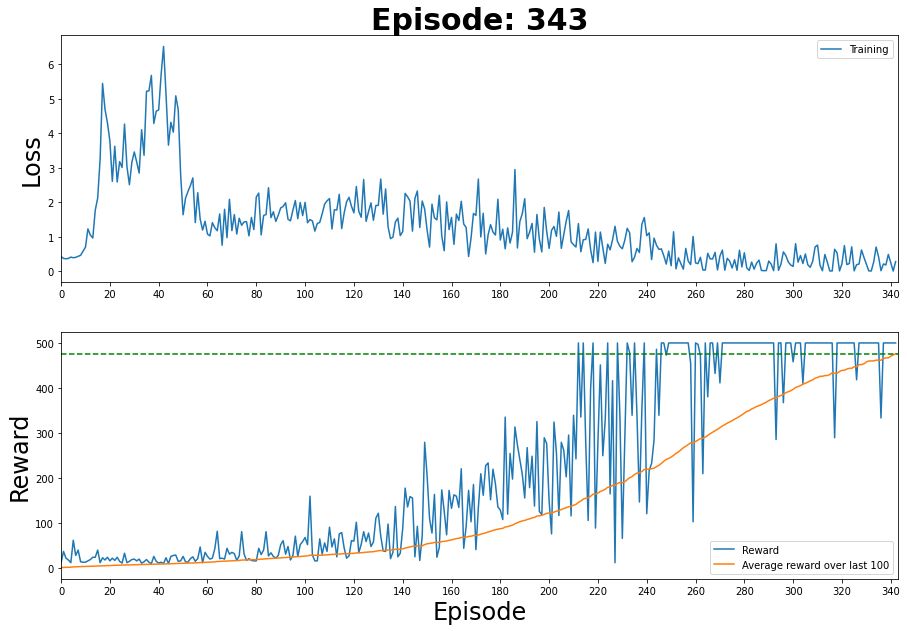

Train loss:  0.28581184
Reward:  500.0
Epsilon:  0.17919120740315364
ERP length:  30000


Environment solved after 343 episodes!
Wall time: 21min 36s


In [37]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.001
replay_buffer_size = 30000
max_episodes = 1000
train_steps = 8
optimization_batch_size= 64
epsilon_decay = 0.995
epsilon_min = 0.1
gamma = 0.95

# Initialize the loss
loss_function = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

env = gym.make("CartPole-v1")

# Initialize model
qnet = QNet([16,16,16], env.action_space.n)
train_qnet(
    model = qnet,
    buffer_size = replay_buffer_size,
    env = env,
    max_episodes = max_episodes,
    train_steps = train_steps,
    batch_size = optimization_batch_size,
    loss_function = loss_function,
    optimizer = optimizer,
    epsilon_decay = epsilon_decay,
    epsilon_min = epsilon_min,
    gamma = gamma
)

# Test the trained Net

In [39]:
observation = env.reset()
reward_sum = 0
for t in range(1000):
    env.render()
    action = qnet.act(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float32),0),0.1).numpy()
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    if done:
        print(f'Episode finished after {t+1} timesteps')        
        print(f'Reward: {reward_sum}')
        break

env.close()

Episode finished after 500 timesteps
Reward: 500.0


# Save model

In [40]:
qnet.save_weights('qnet_CartPole.h5')

# Convert one run to matplot animation and save as video

In [57]:
%%capture
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
fig = plt.figure(figsize=(6,6))
plt.axis("off")

gym_frames = []

observation = env.reset()
done = False
t = 0
while not done:
    img = plt.imshow(env.render(mode='rgb_array'))
    title_txt = f'Step {t}'
    title = plt.text(x = 1, y = -1.7, s = title_txt, fontsize = 18)
    action = qnet.act(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float32),0),0.1).numpy()
    observation, reward, done, info = env.step(action)
    
    gym_frames.append([img,title])
    t += 1
    
env.close() 
gym_anim=animation.ArtistAnimation(fig, gym_frames, interval=50)

In [58]:
gym_anim

In [59]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

gym_anim.save('cartpole.mp4', writer=writer)